In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import numpy as np
from gumbel import *
%matplotlib inline
slim=tf.contrib.slim
Bernoulli = tf.contrib.distributions.Bernoulli

In [2]:
K=10 # number of classes
N=5 # number of categorical distributions

# input image x (shape=(batch_size,784))
x = tf.placeholder(tf.float32,[None,784])
# variational posterior q(y|x), i.e. the encoder (shape=(batch_size,200))
net = slim.stack(x,slim.fully_connected,[512,256])
# unnormalized logits for N separate K-categorical distributions (shape=(batch_size*N,K))
logits_y = tf.reshape(slim.fully_connected(net,K*N,activation_fn=None),[-1,K])
q_y = tf.nn.softmax(logits_y)
log_q_y = tf.log(q_y+1e-20)

In [3]:
# temperature
tau = tf.Variable(5.0,name="temperature")
# sample and reshape back (shape=(batch_size,N,K))
# set hard=True for ST Gumbel-Softmax
y = tf.reshape(gumbel_softmax(logits_y,tau,hard=False),[-1,N,K])
# generative model p(x|y), i.e. the decoder (shape=(batch_size,200))
net = slim.stack(slim.flatten(y),slim.fully_connected,[256,512])
logits_x = slim.fully_connected(net,784,activation_fn=None)
# (shape=(batch_size,784))
p_x = Bernoulli(logits=logits_x)

In [4]:
# loss and train ops
kl_tmp = tf.reshape(q_y*(log_q_y-tf.log(1.0/K)),[-1,N,K])
KL = tf.reduce_sum(kl_tmp,[1,2])
elbo=tf.reduce_sum(p_x.log_prob(x),1) - KL

In [5]:
loss=tf.reduce_mean(-elbo)
lr=tf.constant(0.001)
train_op=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss,var_list=slim.get_model_variables())
init_op=tf.initialize_all_variables()
# get data
data = input_data.read_data_sets('/tmp/', one_hot=True).train 

BATCH_SIZE=100
NUM_ITERS=50000
tau0=1.0 # initial temperature
np_temp=tau0
np_lr=0.001
ANNEAL_RATE=0.00003
MIN_TEMP=0.1

dat=[]
sess=tf.InteractiveSession()
sess.run(init_op)
for i in range(1,NUM_ITERS):
  np_x,np_y=data.next_batch(BATCH_SIZE)
  _,np_loss=sess.run([train_op,loss],{x:np_x,tau:np_temp,lr:np_lr})
  if i % 100 == 1:
    dat.append([i,np_temp,np_loss])
  if i % 1000 == 1:
    np_temp=np.maximum(tau0*np.exp(-ANNEAL_RATE*i),MIN_TEMP)
    np_lr*=0.9
  if i % 5000 == 1:
    print('Step %d, ELBO: %0.3f' % (i,-np_loss))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Step 1, ELBO: -544.121
Step 5001, ELBO: -125.030
Step 10001, ELBO: -118.828
Step 15001, ELBO: -109.978
Step 20001, ELBO: -105.143
Step 25001, ELBO: -112.332
Step 30001, ELBO: -117.215
Step 35001, ELBO: -111.338
Step 40001, ELBO: -113.802
Step 45001, ELBO: -112.314


In [6]:
np_x1,_=data.next_batch(100)
np_x2,np_y1 = sess.run([p_x.mean(),y],{x:np_x1})

In [7]:
import matplotlib.animation as animation

In [8]:
def save_anim(data,figsize,filename):
  fig=plt.figure(figsize=(figsize[1]/10.0,figsize[0]/10.0))
  im = plt.imshow(data[0].reshape(figsize),cmap=plt.cm.gray,interpolation='none')
  plt.gca().set_axis_off()
  #fig.tight_layout()
  fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  def updatefig(t):
    im.set_array(data[t].reshape(figsize))
    return im,
  anim=animation.FuncAnimation(fig, updatefig, frames=100, interval=50, blit=True, repeat=True)
  Writer = animation.writers['imagemagick']
  writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)
  anim.save(filename, writer=writer)
  return

In [9]:
dat=np.array(dat).T

Text(0,0.5,'-ELBO')

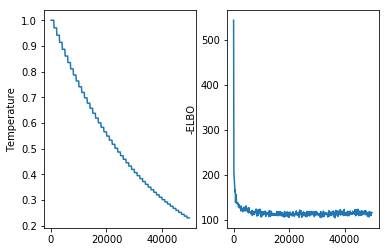

In [10]:
f,axarr=plt.subplots(1,2)
axarr[0].plot(dat[0],dat[1])
axarr[0].set_ylabel('Temperature')
axarr[1].plot(dat[0],dat[2])
axarr[1].set_ylabel('-ELBO')

In [11]:
M=100*N
np_y = np.zeros((M,K))
np_y[range(M),np.random.choice(K,M)] = 1
np_y = np.reshape(np_y,[100,N,K])

In [12]:
x_p=p_x.mean()
np_x= sess.run(x_p,{y:np_y})

In [13]:
np_y = np_y.reshape((10,10,N,K))
np_y = np.concatenate(np.split(np_y,10,axis=0),axis=3)
np_y = np.concatenate(np.split(np_y,10,axis=1),axis=2)
# y_img = np.squeeze(np_y)
y_img = np.reshape(np_y,[-1,K*N]).T

In [14]:
np_x = np_x.reshape((10,10,28,28))
# split into 10 (1,10,28,28) images, concat along columns -> 1,10,28,280
np_x = np.concatenate(np.split(np_x,10,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
np_x = np.concatenate(np.split(np_x,10,axis=1),axis=2)
x_img = np.squeeze(np_x)

Text(0.5,1,'Generated Images')

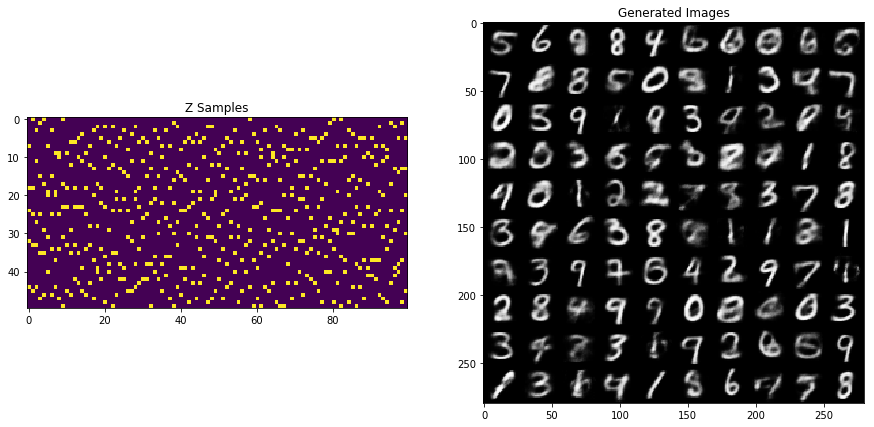

In [15]:
f,axarr=plt.subplots(1,2,figsize=(15,15))
# samples
# axarr[0].matshow(y_img,cmap=plt.cm.gray)
axarr[0].imshow(y_img)
axarr[0].set_title('Z Samples')
# reconstruction
axarr[1].imshow(x_img,cmap=plt.cm.gray,interpolation='none')
axarr[1].set_title('Generated Images')

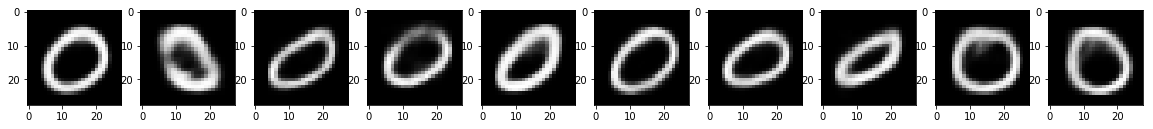

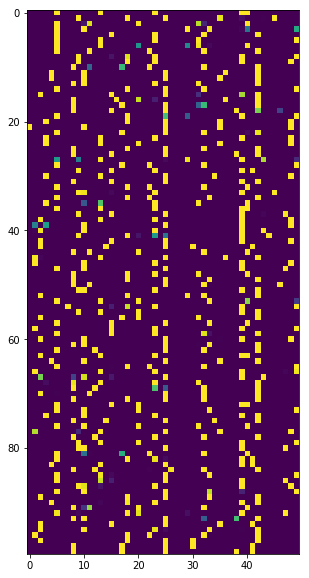

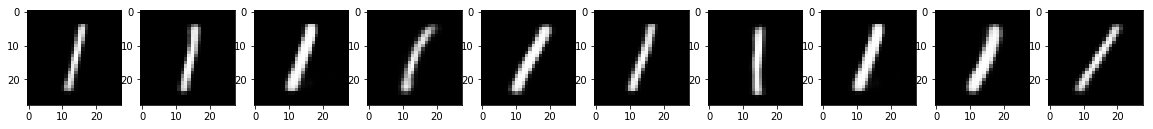

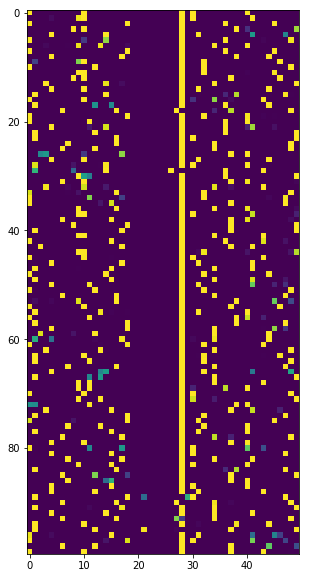

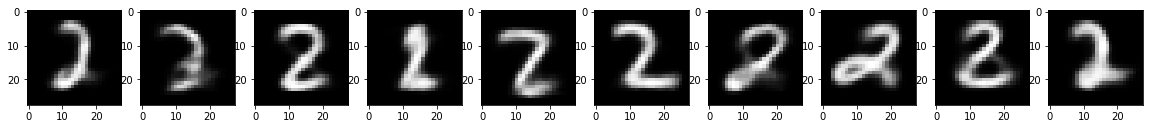

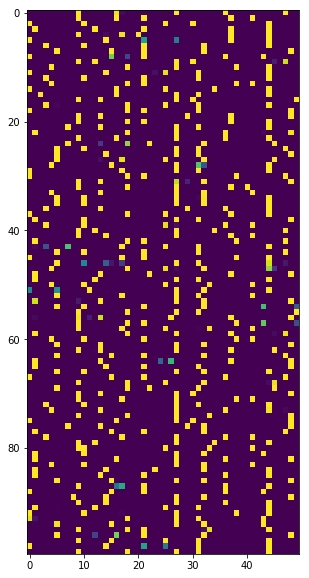

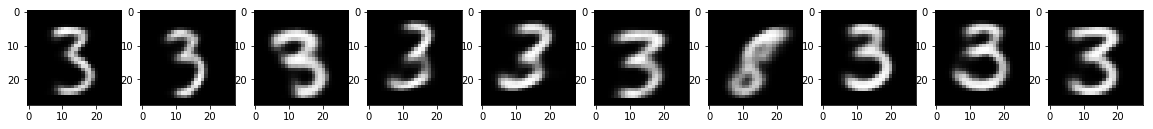

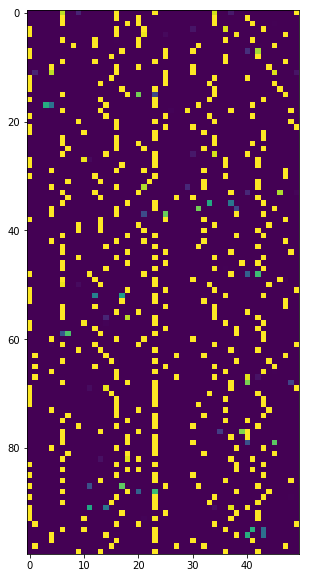

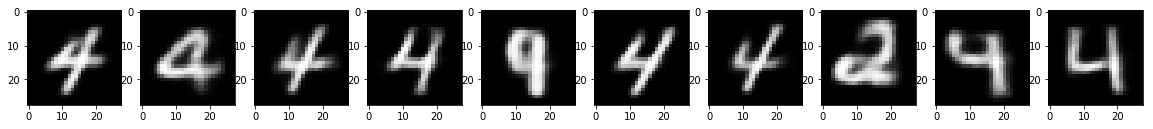

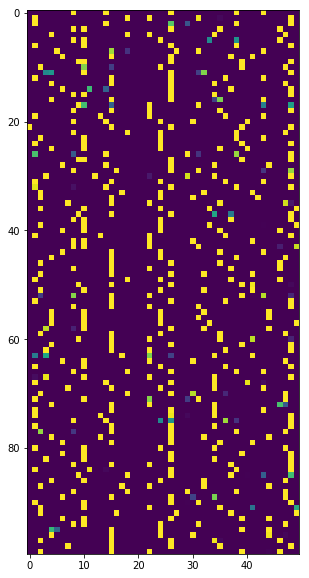

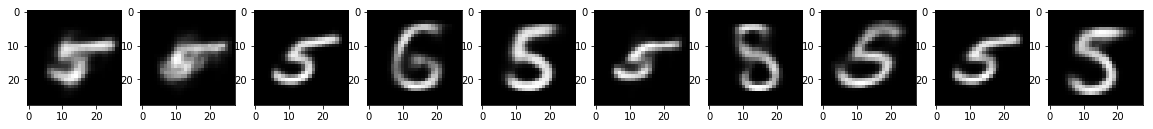

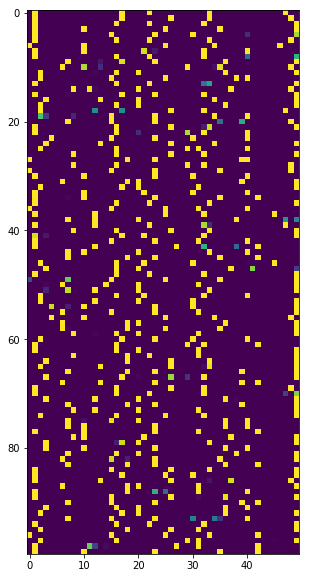

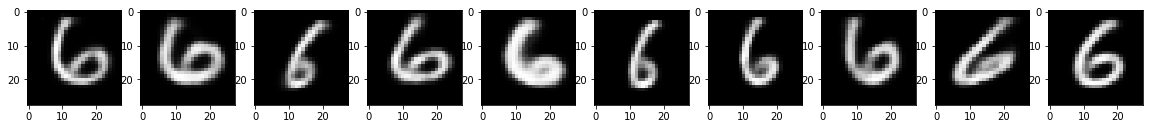

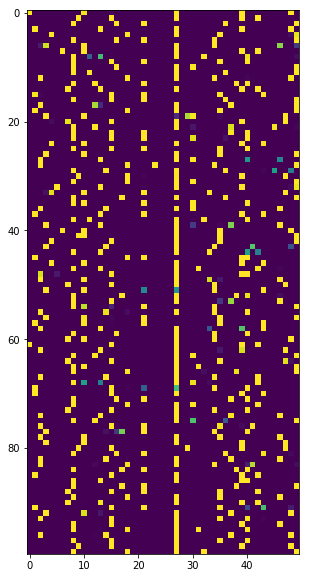

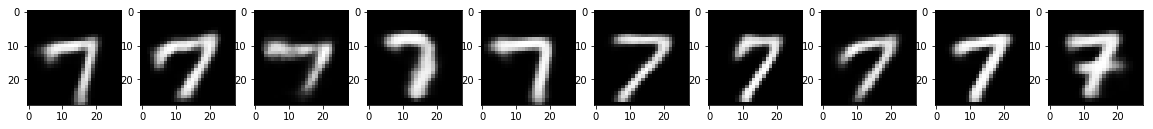

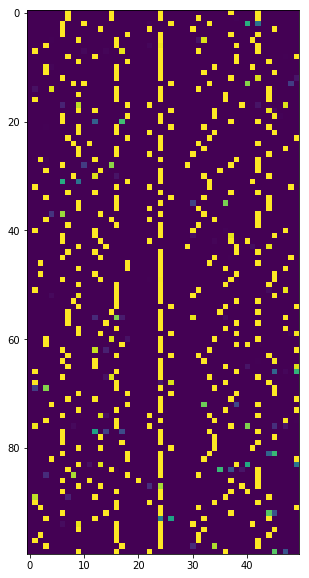

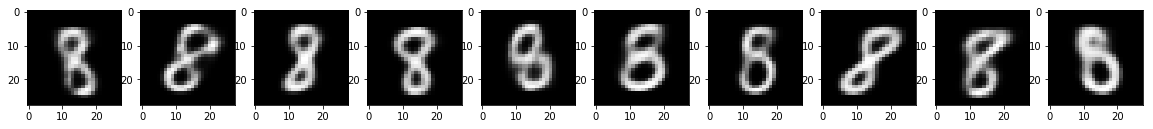

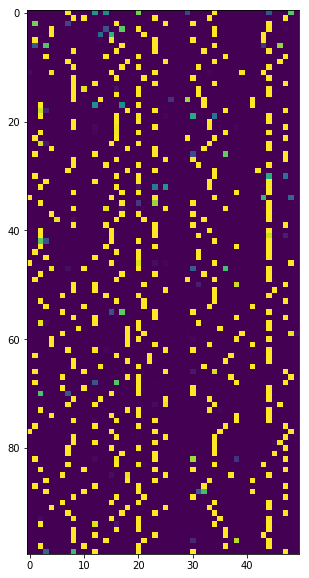

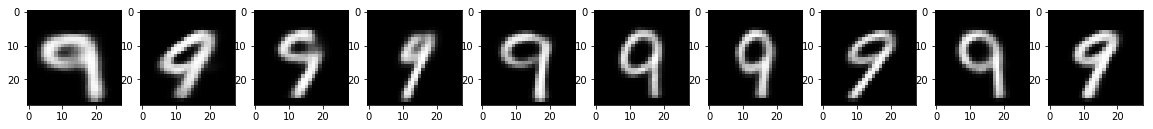

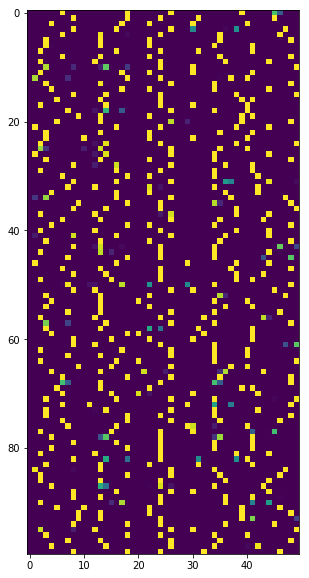

In [16]:
for i in range(10):
    temp_data=data.images[data.labels[:,i]==1,:]
    temp_im=np.reshape(temp_data,[-1,28,28])
    temp_x,temp_y=sess.run([p_x.mean(),y],{x:temp_data[:100,:],tau:MIN_TEMP})
    plt.figure(figsize=(20,20))
    for j in range(10):
        plt.subplot(1,10,j+1)
        plt.imshow(np.reshape(temp_x[j],[28,28]),cmap=plt.cm.gray)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(np.reshape(temp_y,[-1,K*N]))
    plt.show()

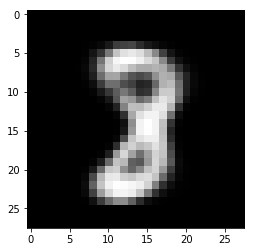

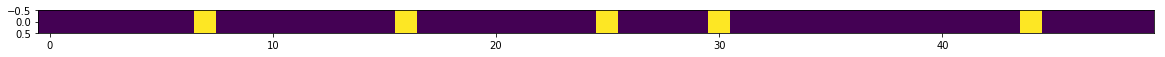

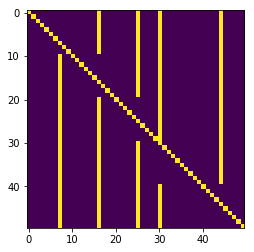

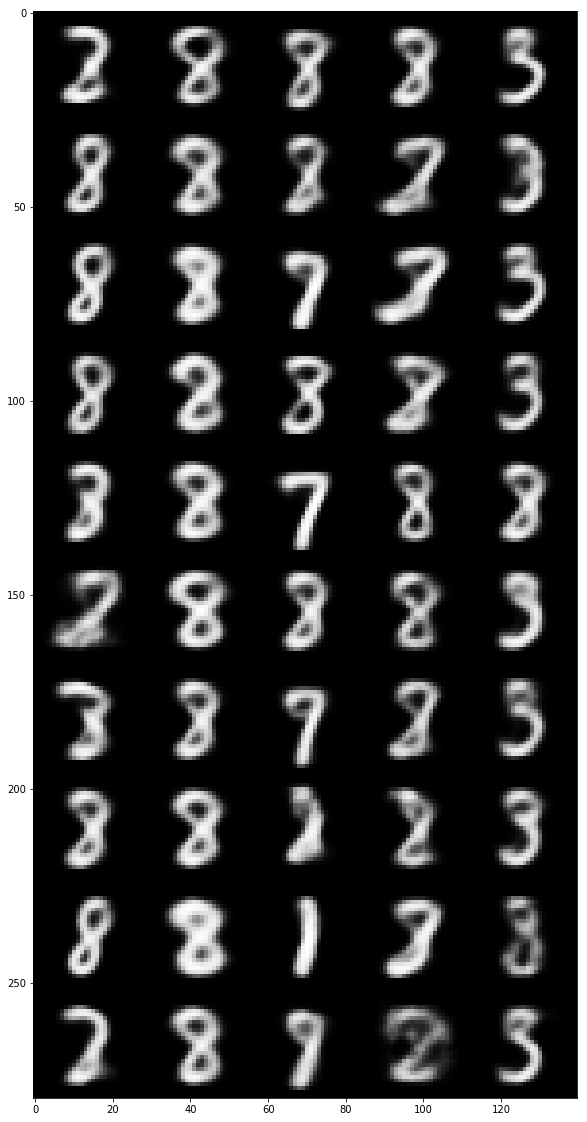

In [19]:
temp_data=data.images[data.labels[:,8]==1,:]
temp_im=np.reshape(temp_data,[-1,28,28])
temp_x,temp_y=sess.run([p_x.mean(),y],{x:temp_data[:100,:],tau:MIN_TEMP})
sample_y = temp_y[[2],:,:]
sample_x = sess.run([p_x.mean()],{y:sample_y,tau:MIN_TEMP})
plt.figure()
plt.imshow(np.reshape(sample_x,[28,28]),cmap=plt.cm.gray)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(np.reshape(sample_y,[-1,K*N]))
plt.show()

sample_latent = np.zeros((N*K,N,K))
for i in range(N):
    for j in range(K):
        sample_latent[i*K+j,:,:] = sample_y
        sample_latent[i*K+j,i,:] = np.zeros(K)
        sample_latent[i*K+j,i,j] = 1

plt.figure()
plt.imshow(np.reshape(sample_latent,[-1,K*N]))
plt.show()

sample_x = sess.run([p_x.mean()],{y:sample_latent,tau:MIN_TEMP})
# plt.figure(figsize=(20,20))
# for i in range(30):
#     for j in range(10):
#         plt.subplot(30,10,i*10+j+1)
#         plt.imshow(np.reshape(sample_x[0][i*10+j],[28,28]))
# plt.show()

sample_x = sample_x[0].reshape((N,K,28,28))
sample_x = np.concatenate(np.split(sample_x,N,axis=0),axis=3)
# split into 10 (1,1,28,280) images, concat along rows -> 1,1,280,280
sample_x = np.concatenate(np.split(sample_x,K,axis=1),axis=2)
sample_x_img = np.squeeze(sample_x)
plt.figure(figsize=(20,20))
plt.imshow(sample_x_img,interpolation='none',cmap=plt.cm.gray)

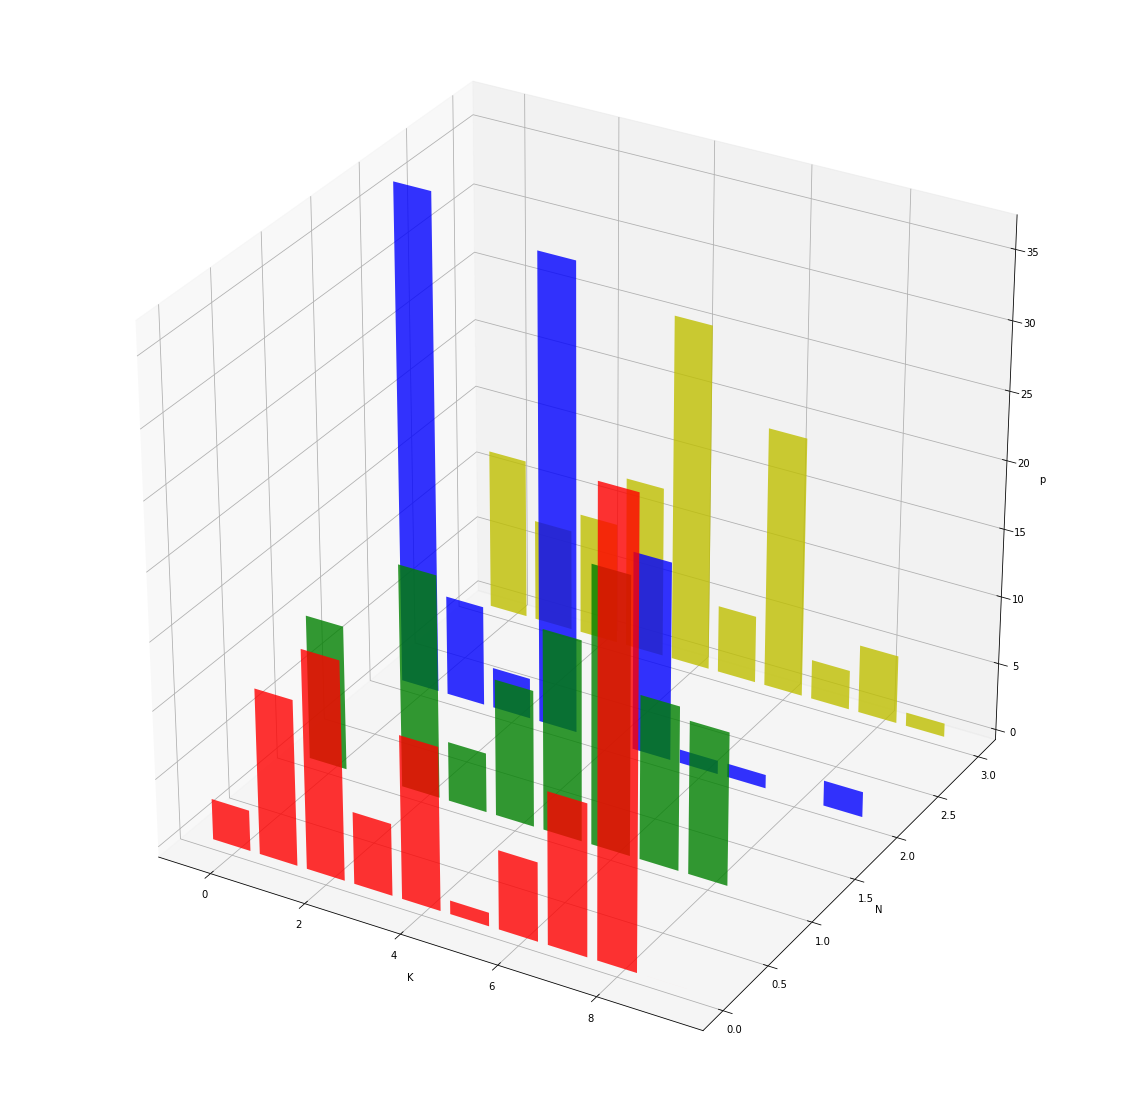

In [18]:
temp_y_total = np.sum(temp_y,axis=0)
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
c = ['r', 'g', 'b', 'y']
for i in range(4):
    xs = np.arange(10)
    ys = temp_y_total[i,:]
    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c[i%4]] * len(xs)
    ax.bar(xs, ys, zs=i, zdir='y', color=cs, alpha=0.8)

ax.set_xlabel('K')
ax.set_ylabel('N')
ax.set_zlabel('p')
plt.show()